In [1]:
!pip install calmap

## Calendar Heatmap

In [1]:
import numpy as np
import pandas as pd
import calmap
import datetime
from string import punctuation
from sklearn.preprocessing import LabelEncoder

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.competition_download_files('competitive-data-science-predict-future-sales')
from zipfile import ZipFile
zf = ZipFile('competitive-data-science-predict-future-sales.zip')
zf.extractall('data/')
zf.close()

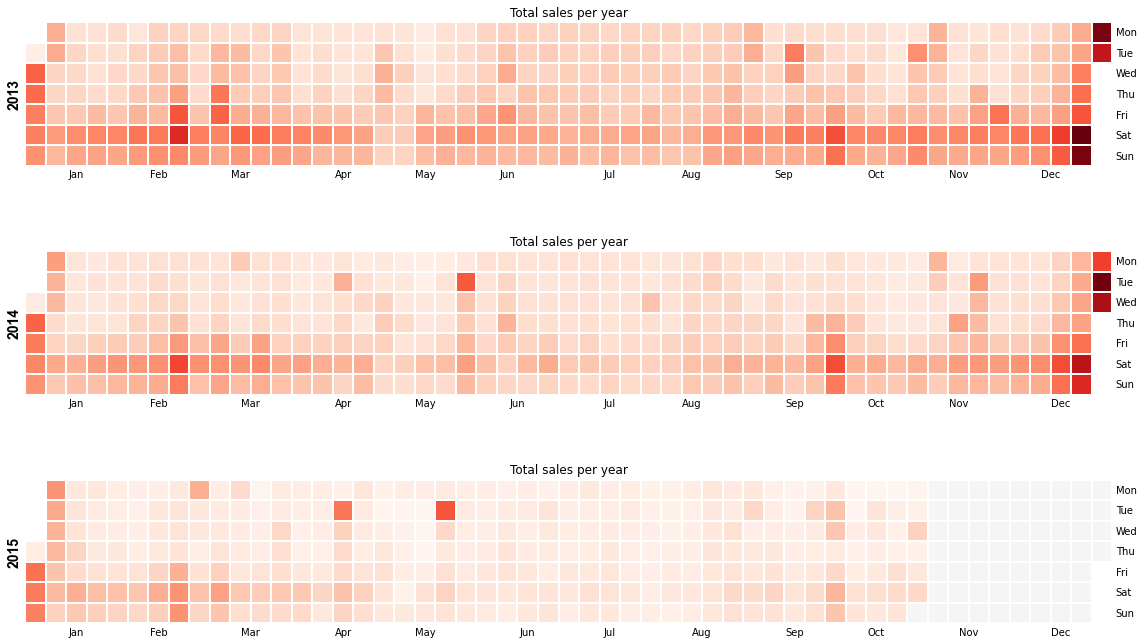

In [3]:
item_category=pd.read_csv("data/item_categories.csv")
items=pd.read_csv("data/items.csv")
sales=pd.read_csv("data/sales_train.csv")
shops=pd.read_csv("data/shops.csv")

# We corrects the shops that we have found to be duplicates.
d = {0:57, 1:58, 10:11, 23:24}
shops["shop_id"] = shops["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)
sales["shop_id"] = sales["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)
    
# replace all the punctuation in the shop_name columns
shops["shop_name_cleaned"] = shops["shop_name"].apply(lambda s: "".join([x for x in s if x not in punctuation]))
    
# extract the city feature for shops
shops["city"] = shops["shop_name_cleaned"].apply(lambda s: s.split()[0])
shops["city_id"] = LabelEncoder().fit_transform(shops['city'])

df = pd.merge(items, item_category, left_on = "item_category_id", right_on = "item_category_id")
df = pd.merge(sales, df, left_on = "item_id", right_on = "item_id")
df = pd.merge(df, shops, left_on = "shop_id", right_on = "shop_id")

df.sort_values(by = ["shop_id", "date"], ascending = True, inplace = True) 

df["date"] = pd.to_datetime(df["date"], format = "%d.%m.%Y")
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month

df_calendar = df[["date", "item_cnt_day"]]
df_calendar.set_index("date", inplace = True)
df_calendar = df_calendar.resample("D")["item_cnt_day"].sum()
calmap.calendarplot(df_calendar,
                    fig_kws = {'figsize': (16,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );


In [4]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_cleaned,city,city_id,Year,Month
3045906,2013-01-01,0,2,2920,599.0,2.0,Disney. LEGO Пираты Карибского моря (Essential...,21,Игры - PSP,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3046804,2013-01-01,0,2,1472,2599.0,1.0,"Assassin's Creed 3 [Xbox 360, русская версия]",23,Игры - XBOX 360,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3047235,2013-01-01,0,2,1905,249.0,1.0,"Bestseller. Grand Theft Auto: San Andreas [PC,...",30,Игры PC - Стандартные издания,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3047928,2013-01-01,0,2,5649,2190.0,1.0,PS3: Файтстик Hori Mini 3,2,Аксессуары - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3048822,2013-01-01,0,2,3320,1999.0,1.0,"FIFA 13 (с поддержкой PS Move) [PS3, русская в...",19,Игры - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1


In [6]:
df.shape

(3222144, 15)

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
train = sales.copy()
train = train.pivot_table(
    index=['shop_id', 'item_id'],
    values=['item_cnt_day'],
    columns=['date_block_num'],
    fill_value=0,
    aggfunc='sum'
).reset_index()

train

shop_id item_id item_cnt_day                       ...        \
date_block_num                            0  1  2  3  4  5  6  7  ... 24 25   
0                    2      27            1  0  0  0  0  0  0  0  ...  0  0   
1                    2      30            0  0  1  0  0  1  0  0  ...  0  0   
2                    2      31            0  4  1  1  0  0  0  0  ...  0  0   
3                    2      32            0  0  0  0  0  0  0  0  ...  0  0   
4                    2      33            1  0  0  0  0  0  0  0  ...  0  1   
...                ...     ...          ... .. .. .. .. .. .. ..  ... .. ..   
416876              59   22154            1  0  0  0  0  0  0  0  ...  0  0   
416877              59   22155            0  0  0  0  0  0  1  0  ...  0  0   
416878              59   22162            0  0  0  0  0  0  0  0  ...  0  9   
416879              59   22164            0  0  0  0  0  0  0  0  ...  0  2   
416880              59   22167            0  0  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  1  
3               1  0  0  0  0  1  0  0  
4               0  1  1  0  1  0  1  0  
...            .. .. .. .. .. .. .. ..  
416876          0  0  0  0  0  0  0  0  
416877          0  0  0  0  0  0  0  0  
416878          4  1  1  0  0  1  0  0  
416879          1  2  0  0  1  0  0  0  
416880          0  0  0  0  0  0  0  0  

[416881 rows x 36 columns]

In [11]:
test = pd.read_csv("data/test.csv")
full_train_df = test.copy()
full_train_df = full_train_df.merge(train, how='left', on=['shop_id', 'item_id']).fillna(0).drop(
    ['ID', 'shop_id', 'item_id'], axis=1)

full_train_df

/Users/danielchen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/danielchen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X_train, y_train = full_train_df.values[:,:-2], full_train_df.values[:, -2:-1].ravel()
X_test = full_train_df.values[:, 2:]

X_train

array([[0., 0., 0., ..., 1., 1., 3.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

result = reg.predict(X_test)

In [15]:
result

array([0.54209522, 0.0330938 , 1.07037851, ..., 0.13308608, 0.0330938 ,
       0.05422171])

In [16]:
result.shape

(214200,)

In [19]:
submission = pd.read_csv("data/sample_submission.csv")
submission['item_cnt_month'] = reg.predict(X_test)
submission = submission[['ID', 'item_cnt_month']]
submission.head()

,ID,item_cnt_month
0,0,0.542095
1,1,0.033094
2,2,1.070379
3,3,0.070911
4,4,0.033094


In [20]:
submission.to_csv(f'output.csv', index=False)

In [30]:
from sklearn.linear_model import Ridge

reg_norm = Ridge(alpha=0.5).fit(X_train, y_train)

result_norm = reg_norm.predict(X_test)

In [31]:
result_norm

array([0.54209633, 0.03309389, 1.0703775 , ..., 0.13308611, 0.03309389,
       0.05422187])

In [ ]:
submission = pd.read_csv("data/sample_submission.csv")
submission['item_cnt_month'] = reg.predict(X_test)
submission = submission[['ID', 'item_cnt_month']]
submission.head()

In [32]:
train = sales.copy()
train_date = train.pivot_table(
    index=['shop_id', 'item_id'],
    values=['item_cnt_day'],
    columns=['date'],
    fill_value=0,
    aggfunc='sum'
).reset_index()

train_date

shop_id item_id item_cnt_day                                   \
date                     01.01.2013 01.01.2014 01.01.2015 01.02.2013   
0            2      27            0          0          0          0   
1            2      30            0          0          0          0   
2            2      31            0          0          0          0   
3            2      32            0          0          0          0   
4            2      33            0          0          0          0   
...        ...     ...          ...        ...        ...        ...   
416876      59   22154            0          0          0          0   
416877      59   22155            0          0          0          0   
416878      59   22162            0          0          0          0   
416879      59   22164            0          0          0          0   
416880      59   22167            0          0          0          0   

                                                    ...                        \
date   01.02.2014 01.02.2015 01.03.2013 01.03.2014  ... 31.07.2014 31.07.2015   
0               0          0          0          0  ...          0          0   
1               0          0          1          0  ...          0          0   
2               0          0          0          0  ...          0          0   
3               0          0          0          0  ...          0          0   
4               0          0          0          0  ...          0          0   
...           ...        ...        ...        ...  ...        ...        ...   
416876          0          0          0          0  ...          0          0   
416877          0          0          0          0  ...          0          0   
416878          0          0          0          0  ...          0          0   
416879          0          0          0          0  ...          0          0   
416880          0          0          0          0  ...          0          0   

                                                                          \
date   31.08.2013 31.08.2014 31.08.2015 31.10.2013 31.10.2014 31.10.2015   
0               0          0          0          0          0          0   
1               0          0          0          0          0          0   
2               0          0          0          0          0          0   
3               0          0          0          0          0          0   
4               0          0          0          0          0          0   
...           ...        ...        ...        ...        ...        ...   
416876          0          0          0          0          0          0   
416877          0          0          0          0          0          0   
416878          0          0          0          0          0          0   
416879          0          0          0          0          0          0   
416880          0          0          0          0          0          0   

                              
date   31.12.2013 31.12.2014  
0               0          0  
1               0          0  
2               0          0  
3               0          1  
4               0          0  
...           ...        ...  
416876          0          0  
416877          0          0  
416878          0          0  
416879          0          0  
416880          0          0  

[416881 rows x 1036 columns]

In [59]:
full_train_df_1 = test.copy()
full_train_df_1 = full_train_df_1.merge(train_date, how='left', on=['shop_id', 'item_id']).fillna(0).drop(
    ['ID', 'shop_id', 'item_id'], axis=1)
full_train_df_1

/Users/danielchen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/danielchen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,"(item_cnt_day, 01.01.2013)","(item_cnt_day, 01.01.2014)","(item_cnt_day, 01.01.2015)","(item_cnt_day, 01.02.2013)","(item_cnt_day, 01.02.2014)","(item_cnt_day, 01.02.2015)","(item_cnt_day, 01.03.2013)","(item_cnt_day, 01.03.2014)","(item_cnt_day, 01.03.2015)","(item_cnt_day, 01.04.2013)",...,"(item_cnt_day, 31.07.2014)","(item_cnt_day, 31.07.2015)","(item_cnt_day, 31.08.2013)","(item_cnt_day, 31.08.2014)","(item_cnt_day, 31.08.2015)","(item_cnt_day, 31.10.2013)","(item_cnt_day, 31.10.2014)","(item_cnt_day, 31.10.2015)","(item_cnt_day, 31.12.2013)","(item_cnt_day, 31.12.2014)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
X_train_1, y_train_1 = full_train_df_1.values[:,:-2], full_train_df_1.values[:, -2:-1].ravel()
reg_1 = LinearRegression().fit(X_train_1, y_train_1)

for i in range(30):
    X_test_1 = full_train_df_1.values[:, 2:]
    full_train_df_1[str(i+1)] = reg_1.predict(X_test_1)
    full_train_df_1.drop(full_train_df_1.columns[0], axis=1, inplace=True)

In [61]:
full_train_df_1

,"(item_cnt_day, 01.11.2013)","(item_cnt_day, 01.11.2014)","(item_cnt_day, 01.12.2013)","(item_cnt_day, 01.12.2014)","(item_cnt_day, 02.01.2013)","(item_cnt_day, 02.01.2014)","(item_cnt_day, 02.01.2015)","(item_cnt_day, 02.02.2013)","(item_cnt_day, 02.02.2014)","(item_cnt_day, 02.02.2015)",...,21,22,23,24,25,26,27,28,29,30
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.116659,0.066890,0.128121,0.049801,-0.066892,-0.035104,-0.012113,0.016950,0.054529,-0.064349
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.084788,0.099793,0.033388,-0.067087,0.031331,-0.049455,-0.082077,-0.008491,0.042775,0.044762
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.069137,0.011216,0.003237,0.073089,-0.009323,-0.010712,0.005986,0.043068,0.017612,-0.006017
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.050449,0.141209,0.007784,-0.065181,0.045921,-0.022932,0.098759,0.010464,-0.060258,0.016903
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904
214197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016208,-0.079916,-0.053307,-0.078218,-0.031480,-0.033089,-0.074605,0.128965,0.113089,0.064645
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904


In [69]:
cols = np.arange(1,31).astype(str)
cols

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30'], dtype='<U21')

In [70]:
output_1 = full_train_df_1[cols]
output_1

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,-0.271528,-0.048391,0.033303,-0.018411,0.020394,-0.169051,-0.243419,0.011277,-0.098795,0.175586,...,0.116659,0.066890,0.128121,0.049801,-0.066892,-0.035104,-0.012113,0.016950,0.054529,-0.064349
1,-0.000865,-0.000865,-0.000873,-0.000852,-0.000851,-0.000845,-0.000822,-0.000820,-0.000827,-0.000785,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904
2,0.022182,0.027170,0.100896,-0.025428,0.054145,-0.155083,-0.030010,-0.042405,-0.098990,0.222324,...,0.084788,0.099793,0.033388,-0.067087,0.031331,-0.049455,-0.082077,-0.008491,0.042775,0.044762
3,0.001571,-0.009812,-0.026017,-0.082163,0.018062,-0.048383,0.012315,-0.024068,0.028663,0.006078,...,0.069137,0.011216,0.003237,0.073089,-0.009323,-0.010712,0.005986,0.043068,0.017612,-0.006017
4,-0.000865,-0.000865,-0.000873,-0.000852,-0.000851,-0.000845,-0.000822,-0.000820,-0.000827,-0.000785,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.045447,0.140381,-0.050792,0.023291,-0.021697,-0.026697,-0.081407,0.051446,-0.054681,0.075584,...,0.050449,0.141209,0.007784,-0.065181,0.045921,-0.022932,0.098759,0.010464,-0.060258,0.016903
214196,-0.000865,-0.000865,-0.000873,-0.000852,-0.000851,-0.000845,-0.000822,-0.000820,-0.000827,-0.000785,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904
214197,0.097071,-0.015669,0.011083,-0.012767,0.047351,0.024287,0.095410,-0.146824,0.044594,0.154867,...,-0.016208,-0.079916,-0.053307,-0.078218,-0.031480,-0.033089,-0.074605,0.128965,0.113089,0.064645
214198,-0.000865,-0.000865,-0.000873,-0.000852,-0.000851,-0.000845,-0.000822,-0.000820,-0.000827,-0.000785,...,-0.000881,-0.000892,-0.000907,-0.000909,-0.000920,-0.000929,-0.000916,-0.000894,-0.000906,-0.000904


In [72]:
output_1.sum(axis=1)

0         0.186903
1        -0.024911
2         0.407474
3         0.013588
4        -0.024911
            ...   
214195    0.423170
214196   -0.024911
214197    0.546626
214198   -0.024911
214199    0.570744
Length: 214200, dtype: float64

In [73]:
submission = pd.read_csv("data/sample_submission.csv")
submission['item_cnt_month'] = reg.predict(X_test)
submission = submission[['ID', 'item_cnt_month']]
submission.head()
submission.to_csv(f'output1.csv', index=False)